# Task Space Decomposition via Convex Optimization

One approach to guaranteeing safe paths during motion planning is to certify that large regions in the search space are collision free. In this problem we'll explore one algorithm, [IRIS](https://groups.csail.mit.edu/robotics-center/public_papers/Deits14.pdf), for accomplishing this.
For manipulation planning, we typically want to certify paths in configuration space.  Simple convex obstacles in 3D become nonconvex when we map them into the joint space of the iiwa!  But for this problem, we'll explore the more straightforward version of IRIS which assumes that obstacles are convex, in a 2D space.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Ellipse
from matplotlib.transforms import Affine2D
from scipy.spatial import HalfspaceIntersection

from matplotlib.animation import FuncAnimation

from pydrake.all import MathematicalProgram, Solve, eq, le, ge
from underactuated import running_as_notebook

We'll start with some helper functions to set up the environment with our obstacles (we are using a random set of triangles) along with some plotting functions

In [4]:
#####################
### Don't change! ###

np.random.seed(1)

seed_point = None
As = []
bs = []
Cs = []
ds = []
tolerance = 0.00001
limits = [[0, 1], [0, 1]]
max_iters = 10

frame_time = 0.25

regions = []
current_region = []

#######################


# Function to set up random set of triangle obstacles
def gen_obstacles():
    n_points = 50

    points = np.random.random(size=(n_points, 2))

    tris = []
    for i, pt in enumerate(points):
        r = np.random.random() * 0.06 + 0.03
        delta1 = r * np.array([np.cos(np.pi / 2), np.sin(np.pi / 2)])
        delta2 = r * np.array(
            [
                np.cos(2 * np.pi / 3 + np.pi / 2),
                np.sin(2 * np.pi / 3 + np.pi / 2),
            ]
        )
        delta3 = r * np.array(
            [
                np.cos(4 * np.pi / 3 + np.pi / 2),
                np.sin(4 * np.pi / 3 + np.pi / 2),
            ]
        )

        tris.append(np.vstack([pt + delta1, pt + delta2, pt + delta3]))

    tris.append(np.array([[0, 0], [1, 0], [0.5, -0.5]]))
    tris.append(np.array([[1, 0], [1, 1], [1.5, 0.5]]))
    tris.append(np.array([[1, 1], [0, 1], [0.5, 1.5]]))
    tris.append(np.array([[0, 1], [0, 0], [-0.5, 0.5]]))

    return tris


# plotting to draw an ellipse
def draw_ellipse(C, d):
    ts = np.linspace(0, 2 * np.pi)
    points = np.array([np.cos(ts), np.sin(ts)])
    points = C @ points + d.reshape(-1, 1)
    ax.plot(*(points))


# plotting to draw intersection of halfspaces
def draw_intersection(A, b, d):
    global current_region
    ineq = np.hstack((A.T, -b))
    hs = HalfspaceIntersection(ineq, d, incremental=False)
    points = hs.intersections
    centered_points = points - d
    thetas = np.arctan2(centered_points[:, 1], centered_points[:, 0])
    idxs = np.argsort(thetas)
    current_region = points[idxs]
    ax.add_patch(Polygon(current_region, color="blue", alpha=0.25))


# plotting
def draw(ax):
    global seed_point, As, bs, Cs, ds, regions
    ax.cla()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    for tri in tris:
        ax.add_patch(Polygon(tri, color="red"))
    if not (seed_point is None):
        ax.scatter([seed_point[0]], [seed_point[1]])
    if len(Cs) > 0:
        C = Cs[-1]
        d = ds[-1]
        draw_ellipse(C, d)
    if len(As) > 0:
        A = As[-1]
        b = bs[-1]
        for i in range(len(b)):
            w = A[:, i]
            intercept = b[i]
            xx = np.linspace(*limits[0])
            yy = (-w[0] / w[1]) * xx + (intercept / w[1])
            ax.plot(xx, yy, color="blue")
        draw_intersection(A, b, ds[-1])
    for region in regions:
        plt.plot(region[:, 0], region[:, 1], color="green", alpha=0.5)
        plt.plot(
            region[[0, -1], 0], region[[0, -1], 1], color="green", alpha=0.5
        )
        ax.add_patch(Polygon(region, color="green", alpha=0.25))

In [7]:
print(tris[0].size)
print(tris[0])

6
[[0.417022   0.76992319]
 [0.37406828 0.69552515]
 [0.45997573 0.69552515]]


Run the cell below to see what the random workspace looks like!

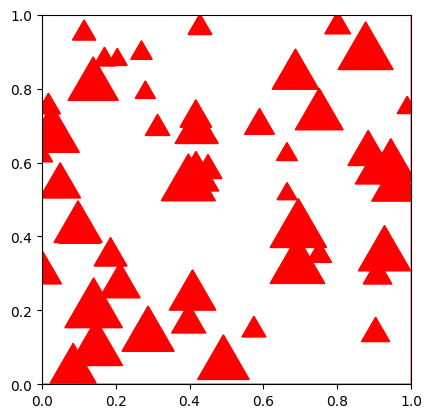

In [6]:
tris = gen_obstacles()
 
fig, ax = plt.subplots()
draw(ax)

# [IRIS](https://groups.csail.mit.edu/robotics-center/public_papers/Deits14.pdf) algorithm 
Our goal with IRIS is to form an explicit representation of large convex subsets of the free space (since [new optimization-based planning algorithms](https://arxiv.org/pdf/2101.11565.pdf) can consume this representation of the free space). Given a seed point (provided by the user) and a small initial ellipse centered at the seed point, IRIS alternates between two steps:
1. Find a set of separating hyperplanes which forms a polytope with the ellipsoid on the inside and all of the obstacles on the outside
2. Obtain a new maximum volume ellipsoid inscribed within the polytope formed by the current set of hyperplanes. 

Each of these steps can be completed using an optimization program. Finding the maximum volume ellipse contained inside an intersection of halfspaces can be written as a semidefinite program. Finding a set of hyperplanes that separates each of the obstacles and an ellipse can be broken into a set of steps:
- For a given convex obstacle in the workspace, represented as its vertex.
- Find the point on the obstacle that is closest to the ellipse. 
- Compute the separating hyper-plane that separates the ellipse from the obstacle and tangents to that point.
- If the obstacles are convex, this plane is guaranteed to have the entire obstacle on one side and the entire ellipse on the other side

**Note about runtime efficiency**
If we repeat this for each obstacle, the intersection of each halfspace formed by the tangent planes we compute are guaranteed to contain the ellipse and none of the obstacles. However, if perform each step in an environment with many obstacles, we might perform a lot of redundant computation. It is far more efficient if, on each iteration, we check if any of the *other* obstacles also satisfy the constraint of being fully on one side of the hyperplane we compute from the tangent. If this constraint is already satisfied for a hyperplane that's already been computed, we don't have to compute a new one for this obstacle. 

The following cell block sets up some of the helper functions involved in these steps. In the cells below, you are required to implement the logic for `SeparatingHyperplanes` and the QP in `ClosestPointOnObstacle`. 


In [ ]:
# Helper functions


def TangentPlane(C, C_inv2, d, x_star):
    a = 2 * C_inv2 @ (x_star - d).reshape(-1, 1)
    b = np.dot(a.flatten(), x_star)
    return a, b


def update_polytope(A, b, d):
    global current_region
    ineq = np.hstack((A.T, -b))
    hs = HalfspaceIntersection(ineq, d, incremental=False)
    points = hs.intersections
    centered_points = points - d
    thetas = np.arctan2(centered_points[:, 1], centered_points[:, 0])
    idxs = np.argsort(thetas)
    current_region = points[idxs]


def InscribedEllipsoid(A, b):
    n = 2

    prog = MathematicalProgram()

    C = prog.NewContinuousVariables(n, n)
    d = prog.NewContinuousVariables(n)
    prog.AddPositiveSemidefiniteConstraint(C)
    prog.AddMaximizeLogDeterminantCost(C)

    for ai, bi in zip(A.T, b):
        z0 = bi - ai.T @ d
        z1 = ai.T @ C
        z = np.concatenate([z0, z1])
        prog.AddLorentzConeConstraint(z)

    result = Solve(prog)

    C_best, d_best = result.GetSolution(C), result.GetSolution(d)

    return C_best, d_best

### Your turn to code - `ClosestPointOnObstacle`
Implement `ClosestPointOnObstacle` function in page 10 (equation 4) of the IRIS paper. The implementation should have the following steps:
 - Compute the closest point to the origin in the transformed ("ball space") obstacle. 
 - Transform that point back to the original "ellipsoid space". 

Follow the description in the paper to implement the algorithm. Here are some useful sections to understand how the QP works:
> Our ellipsoid $\mathcal{E}$ is defined as an image of the unit ball in $\mathbb{R^n}$: $\mathcal{E} = \{ C\tilde{x} + d ~|~ ||\tilde{x}|| \leq 1 \}$ , so we construct the inverse of this image map: $\tilde{v}_{j, k} = C^{-1}(v_{j, k} - d)$ (where $v_{j,k}$ is the k-th vertex of the j-th obstacle)

> This optimization yields a point $\tilde{x}^{*}$. Applying the original map gives $x^{*} = C\tilde{x}^{*} + d$, which is the point on obstacle j closest to the ellipsoid.

Using this description (along with any other relevant details from the paper) along with the mathematical description of the QP below, implement the mapping from/to ball-to-ellipsoid space and implement the quadratic program using Drake's `MathematicalProgram`. 
 
Here is the QP we want you to implement in code (see Eq. (4) in the paper):

$$\begin{aligned} \underset{\tilde{x} \in \mathbb{R}^{n}, w \in \mathbb{R}^{m}}{\text{arg}\min} \quad & ||\tilde{x}||^{2} \\ \textrm{s.t.} \quad & [\tilde{v}_{j, 1}, \tilde{v}_{j, 2} ... \tilde{v}_{j, m}]w = \tilde{x}\\ \quad & \sum_{i=1}^{m}w_i = 1 \\ \quad & w_i \geq 0 \end{aligned}$$

In [ ]:
def ClosestPointOnObstacle(C, C_inv, d, o):
    """
    Computes the closest point on a convex polygonal obstacle (described
    in terms of its vertices) to an ellipse described by a positive
    semidefinite matrix applied to a unit sphere and a center point.

    Args:
        C (np.ndarray): Shape (2, 2), positive semidefinite matrix,
            describing the ellipse (i.e., Ellipse = {Cx + d | ||x|| < 1})
        C_inv (np.ndarray): Shape (2, 2), precomputed inverse of C
        d (np.ndarray): Shape (2,), center point of the ellipse
        o (np.ndarray): Shape (3, 2), containing the 2D coordinates
            of the vertices on the convex (triangular) obstacle

    Returns:
        np.ndarray: Shape (2,), 2D coordinate of the closest point on the
            obstacle to the ellipse
        float: Distance from the center of the ellipse to the sample point
            (in the ellipsoidal metric)

    """
    v_tildes = C_inv @ (o - d).T
    n = 2
    m = len(o)

    prog = MathematicalProgram()
    x_tilde = prog.NewContinuousVariables(n)
    w = prog.NewContinuousVariables(m)

    """
    Your code here (set up a QP to find the closest point
    on the obstacle defined by the corners in o)
    """

    x_star = np.zeros(n)
    dist = np.inf

    return x_star, dist

### Your turn to code - `SeparatingHyperplane`

Implement `SeparatingHyperplane` function in page 11 (Algorithm 2) of the IRIS paper. The implementation should have the following steps:      
        - Find the closest obstacle to the center of the ellipsoid
        - Find the closest point on this obstacle to the ellipsoid
        - Compute the tangent plane (represented via a normal and an offset)
        - Save the parameters of the tangent plane (so that we can build an intersection of the half spaces represented by these planes)
        - Check if this half plane allows us to check of any other obstacles in the same iteration (i.e., if other obstacles also satisfy the condition of being fully on one side of the plane, with the ellipse on the other side, then we can remove them from out list of remaining obstacles)
     
Here is the pseudocode for this algorithm from the IRIS paper:
<img src="https://raw.githubusercontent.com/anthonysimeonov/manipulation/master/figures/exercises/iris_sep_hyperplane_opt.png" width="500"> 

You should use the `ClosestPointOnObstacle` function you implemented, as well as the `TangentPlane` and `InscribedEllipsoid` functions we provided above. 

**hint** -- don't forget to check and remove any additional obstacles that you can with the hyperplane you compute on each iteration!

In [ ]:
def SeparatingHyperplanes(C, d, O, max_iters=40):
    """
    Finds a set of separating hyperplanes between a set of
    convex obstacles and an ellipsoid.

    Args:
        C (np.ndarray): Shape (2, 2), positive semidefinite matrix,
            describing the ellipse (i.e., Ellipse = {Cx + d | ||x|| < 1})
        d (np.ndarray): Shape (2,), center point of the ellipse
        O (list): Length is the number of obstacles, each element
            contains a (3, 2) numpy array containing the 2D coordinates
            of the vertices on the convex (triangular) obstacle
        max_iters (int): Maximum iterations

    Returns:
        np.ndarray: Shape (2, N) (where N is the number of hyperplanes you found),
            each column represents the normal of one hyperplane
            (i.e., a in a.T @ x = b)
        np.ndarray: Shape (N, 1) (where N is the number of hyperplanes you found),
            each row represents the offset of one hyperplane
            (i.e., b in a.T @ x = b)
        bool: True if solution is found within maximum number of iterations, else False

    """
    C_inv = np.linalg.inv(C)
    C_inv2 = C_inv @ C_inv.T
    O_excluded = []
    O_remaining = O
    ais = []
    bis = []
    iters = 0
    solution_found = False
    while len(O_remaining) > 0:
        iters += 1
        if iters > max_iters:
            print("Maximum iterations reached")
            return None, None, solution_found

        """
        Your code here
        - Find the closest obstacle to the center of the ellipsoid
        - Find the closest point on this obstacle to the ellipsoid
        - Compute the tangent plane
        - Save the parameters of the tangent plane to build an intersection of half spaces
        - Check if this half plane allows us to check of any other obstacles in the same iteration
        """

    solution_found = True
    A = np.array(ais).T[0]
    b = np.array(bis).reshape(-1, 1)
    return A, b, solution_found

Once you have these functions running, you can run the two cell blocks below to perform the full optimization, and show the final result along with an animation of the iterations performed by the optimizer. 

If you want to view the intermediate results along the way to debug what your implementations are doing, you can set `plot_debug` to True, and view the halfspaces you create and the ellipsoids that are contained within them. 

In [ ]:
plot_debug = False


def optim():
    global As, bs, Cs, ds, seed_point, regions, current_region
    As = []
    bs = []
    Cs = []
    ds = []

    C0 = np.eye(2) * 0.01
    Cs.append(C0)
    ds.append(seed_point.copy())
    O = tris

    iters = 0
    sol_found = True

    while True:
        print("Iteration %d" % iters)

        iters += 1

        if iters > max_iters:
            sol_found = False
            break

        A, b, hyp_sol = SeparatingHyperplanes(Cs[-1], ds[-1], O.copy())
        if not hyp_sol:
            print('Couldn"t find hyperplanes')
            continue
        As.append(A)
        bs.append(b)

        if running_as_notebook and plot_debug:
            fig, ax = plt.subplots()
            draw(ax)
            plt.show()

        C, d = InscribedEllipsoid(As[-1], bs[-1])
        Cs.append(C)
        ds.append(d)

        if (np.linalg.det(Cs[-1]) - np.linalg.det(Cs[-2])) / np.linalg.det(
            Cs[-2]
        ) < tolerance:
            break

    print("Done")

    if sol_found:
        update_polytope(As[-1], bs[-1], ds[-1])
        regions.append(current_region)

    return As, bs, Cs, ds, sol_found

In [ ]:
regions = []
current_region = []

seed_point = np.array([0.2, 0.61])
As, bs, Cs, ds, sol_found = optim()
print(f"Solution found: {sol_found}")


def ani_draw(ii):
    global seed_point, As, bs, Cs, ds, regions
    ax.cla()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    eps = 1e-7
    for tri in tris:
        ax.add_patch(Polygon(tri, color="red"))

    if not (seed_point is None):
        ax.scatter([seed_point[0]], [seed_point[1]])

    if len(Cs) > 0:
        C = Cs[ii]
        d = ds[ii]
        draw_ellipse(C, d)
    if len(As) > 0:
        A = As[ii]
        b = bs[ii]
        for i in range(len(b)):
            w = A[:, i]
            intercept = b[i]
            xx = np.linspace(*limits[0])
            yy = (-w[0] / (w[1] + eps)) * xx + (intercept / (w[1] + eps))
            ax.plot(xx, yy, color="blue")
        draw_intersection(A, b, ds[-1])

    if ii == (len(As) - 1):
        for region in regions:
            plt.plot(region[:, 0], region[:, 1], color="green", alpha=0.5)
            plt.plot(
                region[[0, -1], 0],
                region[[0, -1], 1],
                color="green",
                alpha=0.5,
            )
            ax.add_patch(Polygon(region, color="green", alpha=0.25))


from IPython.display import HTML, display

if sol_found:
    fig, ax = plt.subplots()
    anim = FuncAnimation(fig, ani_draw, frames=len(As), interval=500)

    from IPython.display import HTML

    display(HTML(anim.to_jshtml()))
else:
    print("No solution found, nothing to plot")

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `taskspace_iris.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [4 pts] `ClosestPointOnObstacle` must be implemented correctly. 
- [4 pts] `SeparatingHyperplanes` must be implemented correctly.

In [ ]:
from manipulation.exercises.trajectories.test_taskspace_iris import (
    TestTaskspaceIRIS,
)
from manipulation.exercises.grader import Grader

Grader.grade_output([TestTaskspaceIRIS], [locals()], "results.json")
Grader.print_test_results("results.json")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f04667bf-32a3-4462-9e65-eda0faf36cb4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>